## In this notebook I am gonna using trained neural networks manually fine tunes their results to get wonderful results of segmenting

In [1]:
%run dataset_loader.py
%run UNET.py
%run sift.py

In [2]:
import os
import torch
import random

import matplotlib.pyplot as plt
from scipy import misc
from PIL import Image

IMG_PATH_TRAIN = "./BBBC018_v1_images-fixed/train/"
OUTLINE_PATH_TRAIN = "./BBBC018_v1_outlines/train/"

IMG_PATH_TEST = "./BBBC018_v1_images-fixed/val/"
OUTLINE_PATH_TEST = "./BBBC018_v1_outlines/val/"

In [3]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), # Real Image are heavy
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
])

/home/boyarintsev.artem/catboost/venv/lib/python3.6/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


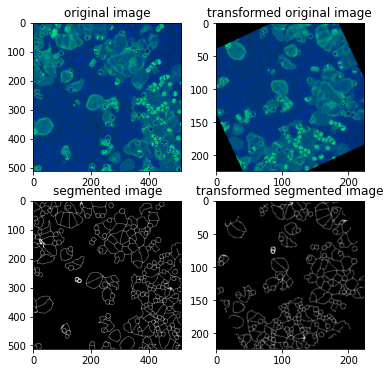

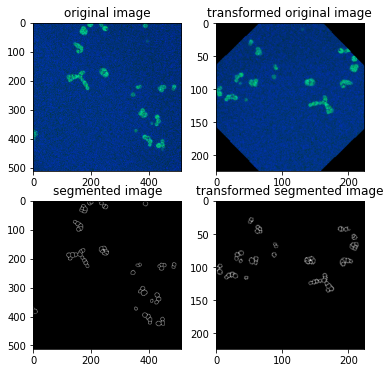

In [4]:
Train = get_dataset(transform_train, IMG_PATH_TRAIN, OUTLINE_PATH_TRAIN, show_examples_amount=2)

In [5]:
Test = get_dataset(transform_train, IMG_PATH_TEST, OUTLINE_PATH_TEST, show_examples_amount=1)

In [6]:
net = UNET().double().cuda()
net.load_state_dict(torch.load("./UNET_weights.save"))

<All keys matched successfully>

### Let's ensure that we correctly loaded weights and dataset

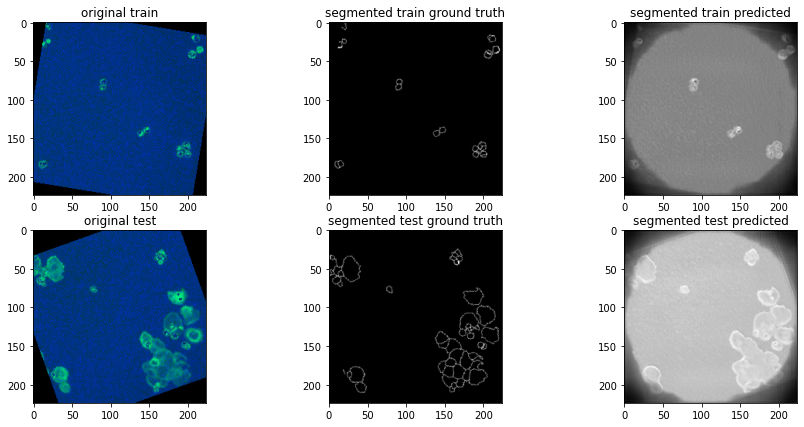

In [7]:
sift(net, Train, Test)

In [8]:
img = Test[:1,:3].cuda()
net_segmented = net(img)

In [9]:
net_segmented_numpy = net_segmented.detach().cpu().numpy()
net_segmented_numpy = net_segmented_numpy[0].transpose(1,2,0)

In [10]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union


def calc_dice(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        dice_denumerator = np.sum(prediction[i] > 0) + np.sum(ground_truth[i] > 0)
        
    return float(intersection) / dice_denumerator

In [11]:
calc_iou(net_segmented_numpy > 0.041, Test[0,3].numpy())

0.2327533807121834

0.18558554155924292
35.06382277114935


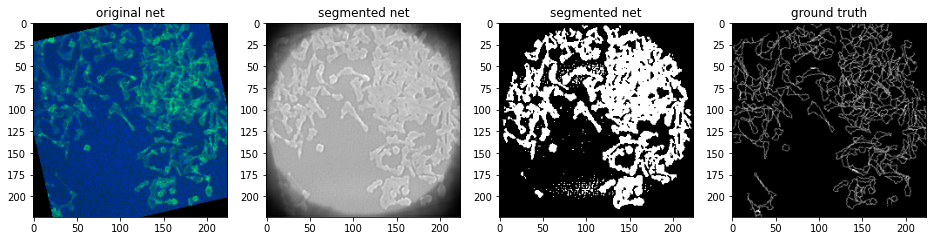

In [12]:
thres = 0.04

f, ax = plt.subplots(1,4, figsize=(16,8))
ax[0].set_title('original net')
ax[0].imshow(Test[0,:3].detach().numpy().transpose(1,2,0).clip(0,1), 'gray')

ax[1].set_title('segmented net')
ax[1].imshow(net_segmented_numpy.clip(0,1), 'gray')

ax[2].set_title('segmented net')
ax[2].imshow(net_segmented_numpy.clip(0,1) > thres, 'gray')

ax[3].set_title('ground truth')
ax[3].imshow(Test[0,3].numpy().clip(0,1), 'gray')

print(calc_iou([net_segmented_numpy > thres], [Test[0,3].numpy()]))
print(calc_dice([net_segmented_numpy > thres], [Test[0,3].numpy()]))

In [13]:
gaussian = np.array([[2.0/159,4.0/159,5.0/159,4.0/159,2.0/159 ], 
                     [4.0/159,9.0/159,12.0/159,9.0/159,4.0/159],
                     [5.0/159,12.0/159,15.0/159,12.0/159,5.0/159],
                     [4.0/159,9.0/159,12.0/159,9.0/159,4.0/159],
                     [2.0/159,4.0/159,5.0/159,4.0/159,2.0/159]
                    ])

In [14]:
conv2d = nn.Conv2d(1, 1,kernel_size=5, padding=1, bias=False).double()

In [15]:
state_dict = conv2d.state_dict()
for x in range(0, len(gaussian)):
    state_dict['weight'][0,0,x] = torch.from_numpy(gaussian[x])
conv2d.load_state_dict(state_dict)

<All keys matched successfully>

In [16]:
torch_img_numpy = torch.from_numpy((net_segmented_numpy).transpose(2,0,1)).double()
converted_gaussian = conv2d(torch_img_numpy[None])

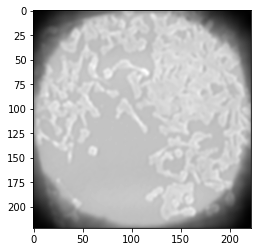

In [17]:
plt.imshow(converted_gaussian.detach().numpy()[0][0], 'gray')

In [18]:
def killNotMaximums(sobels, iStart, jStart, bitmap):
    maximum = np.zeros(shape=2)

    for i in range(iStart, iStart+3):
        if ( i >= sobels.shape[0]):
            break;

        for j in range(jStart, jStart+3):
            if (j >= sobels.shape[1]):
                break;

            if (maximum[0] < sobels[i][j][0]):
                maximum = sobels[i][j];

    for i in range(iStart, iStart+3):
        if (i >= sobels.shape[0]):
            break;
        for j in range(jStart, jStart+3):
            if (j >= sobels.shape[1]):
                break;
            if (sobels[i][j][1] >= maximum[1] -delta and sobels[i][j][1] <= maximum[1] + delta and threshold <= sobels[i][j][0]):
                bitmap[i][j] = 255
            else:
                bitmap[i][j] = 0
                
                
def applySobel(bitmap):
    width = bitmap.shape[0];
    height = bitmap.shape[1];
    sobels = np.zeros(shape=(width-2,height-2, 2))
    for i in range(0, width-2):
        for j in range(0, height-2):
            sx = getAbsoluteValue(bitmap[i+2][j])+2*getAbsoluteValue(bitmap[i+2][j+1]) +getAbsoluteValue(bitmap[i+2][j+2]) - getAbsoluteValue(bitmap[i][j]) - 2 * getAbsoluteValue(bitmap[i][j+1]) - getAbsoluteValue(bitmap[i][j+2])

            sy = getAbsoluteValue(bitmap[i][j+2]) + 2 * getAbsoluteValue(bitmap[i+1][j+2]) + getAbsoluteValue(bitmap[i+2][j+2]) - getAbsoluteValue(bitmap[i][j]) - 2* getAbsoluteValue(bitmap[i+1][j])- getAbsoluteValue(bitmap[i+2][j])

            sum = math.sqrt(sx*sx+sy*sy)
            sobels[i][j][0] = sum
            sobels[i][j][1] = math.atan((sx/sy))

    return sobels


def getAbsoluteValue(c):
    return np.max(c)

In [19]:
import math
sobels = applySobel(net_segmented_numpy)

In [20]:
converted_gaussian_numpy = converted_gaussian.detach().numpy()[0][0]

In [21]:
delta = 0.1
threshold=0.008

In [22]:
bitmapOfConverted = converted_gaussian_numpy.copy()

In [23]:
for i in range(0, sobels.shape[0]):
    for j in range(0, sobels.shape[1]):
        killNotMaximums(sobels,i,j,bitmapOfConverted)

0.20304279823688326

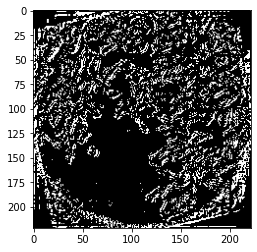

In [24]:
plt.imshow(bitmapOfConverted, 'gray')
calc_iou(bitmapOfConverted, Test[0,3,1:-1,1:-1].numpy())